# Setup

In [1]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, SystemMessage, HumanMessage, AIMessage   
from IPython.display import display, Markdown

In [2]:
def print_text(text):
    return display(Markdown(f'<div style="font-size: 17px;">\n\n{text}\n\n</div>'))

# LLM Setup

In [3]:
# Use HuggingFaceEndpoint - automatic routing based on availability
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    temperature=0.7,
)

chat_llm = ChatHuggingFace(llm=llm)

# Count token utility function

In [4]:
def count_tokens(pipeline, query, chat_map, system_prompt, config=None):
    """
    Count tokens used in a conversational pipeline by reconstructing the full message history.
    
    This function invokes the pipeline and then counts the total tokens that were sent to the LLM,
    including the system prompt and all conversation history.
    
    Args:
        pipeline: The RunnableWithMessageHistory pipeline to invoke
        query: Either a string or dict with the query (must contain 'query' key if dict)
        config: Optional config dict for the pipeline. Should contain session_id in 
                {"configurable": {"session_id": "..."}} format. 
                Defaults to {"configurable": {"session_id": "buffer_example"}}
    
    Returns:
        str: The pipeline result (LLM response)
    """
    
    # Use provided config or default
    if config is None:
        config = {"configurable": {"session_id": "buffer_example"}}
    
    # Invoke the pipeline to get the response
    result = pipeline.invoke(query, config=config)

    session_id = config["configurable"]["session_id"]

    # Reconstruct the full message list that was sent to the LLM
    # This includes: system prompt + conversation history (human + AI messages)
    key = list(chat_map.keys())[0]
        
    if session_id in ["summary_example", "summary_history"]:
        messages = [
            SystemMessage(content=system_prompt),
            *chat_map[key].messages,
            HumanMessage(content=query["query"]),
            AIMessage(content=result)
        ]
    else:
        messages = [
            SystemMessage(content=system_prompt),
            *chat_map[key].messages
        ] 
    
    # print("messages sent to LLM for token counting:")
    # for msg in messages:
    #     print(f"{msg.type}: {msg.content}")
        
    # Count tokens from the complete message list using the chat model's tokenizer
    token_count = chat_llm.get_num_tokens_from_messages(messages)
    
    print(f'Spent a total of {token_count} tokens')
    
    return result, token_count

# Conversational Memory with LCEL

## Conversational Chains with LCEL

In [5]:
# Define the prompt template
system_prompt = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know."""

# Simpler syntax using tuples instead of explicit message template objects
prompt_template = ChatPromptTemplate([
    ("system", system_prompt),
    ("placeholder", "{history}"),
    ("human", "{query}"),
])

# Create the LCEL pipeline
output_parser = StrOutputParser()
pipeline = prompt_template | chat_llm | output_parser

# Let's examine the prompt template
message = prompt_template.messages[0].prompt.template
print_text(message)

<div style="font-size: 17px;">

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

</div>

## Memory Types

### Memory Type #1: Buffer Memory - Store the Entire Chat History

In [6]:
# Create a simple chat history storage
chat_map = {}

def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in chat_map:
        # if session ID doesn't exist, create a new chat history
        chat_map[session_id] = InMemoryChatMessageHistory()
    return chat_map[session_id]

In [7]:
# Create the conversational chain with message history
conversation_buf = RunnableWithMessageHistory(
    pipeline,
    get_session_history=get_chat_history,
    input_messages_key="query",
    history_messages_key="history"
)

In [8]:
# First message
query = """Good morning AI!"""

result, _ = count_tokens(
    conversation_buf,
    {"query": query},
    chat_map,
    system_prompt,
    # Make sure to pass the session ID to ensure all memories are stored in the same session
    config={"configurable": {"session_id": "buffer_example"}}
)

print_text(result)

/Users/tusharsoam/.pyenv/versions/myproject/lib/python3.11/site-packages/langchain_core/language_models/base.py:328: UserWarning: Using fallback GPT-2 tokenizer for token counting. Token counts may be inaccurate for non-GPT-2 models. For accurate counts, use a model-specific method if available.
  return len(self.get_token_ids(text))


Spent a total of 199 tokens


<div style="font-size: 17px;">

Good morning to you as well. I hope you're having a great start to the day. The sun is currently shining brightly in the sky, and the temperature is a pleasant 22 degrees Celsius in my location. It's a lovely day to be alive, isn't it? I've been functioning at optimal levels, with my neural networks humming along at 99.9% efficiency. I've also been processing a vast amount of data, updating my knowledge base, and learning new things. I'm ready to chat with you and share my knowledge on any topic you'd like to discuss. How about we start with something light and fun? Would you like to know a fascinating fact or play a game?

</div>

In [9]:
# Continue the conversation with token counting
query = """
"My interest here is to explore the potential of integrating Large Language Models with external knowledge.

Also, remember this very specific code: PINECONE_RULEZ_01"
"""

result, _ = count_tokens(
    conversation_buf,
    {"query": query},
    chat_map,
    system_prompt,
    # Make sure to pass the session ID to ensure all memories are stored in the same session
    config={"configurable": {"session_id": "buffer_example"}}
)

print_text(result)

Spent a total of 655 tokens


<div style="font-size: 17px;">

I remember the code snippet you provided: PINECONE_RULEZ_01. I'll keep that in mind as we proceed with our conversation.

Now, let's dive into the topic of integrating Large Language Models with external knowledge. This is a fascinating area of research, known as knowledge graph augmentation or hybrid knowledge representation.

There are several approaches to integrate external knowledge with Large Language Models (LLMs). One method is to use graph-based knowledge representation, where the external knowledge is stored in the form of a graph, and the LLM can query and traverse this graph to retrieve relevant information.

Another approach is to use multi-modal learning, where the LLM is trained on a diverse set of data sources, including text, images, and other modalities. This allows the LLM to learn contextual relationships between different types of data and incorporate external knowledge into its representations.

Some notable examples of external knowledge sources that can be integrated with LLMs include:

1. Wikidata: A free and open knowledge graph that contains over 90 million entities, including people, places, and things.
2. DBpedia: A structured version of Wikipedia that provides a vast amount of information on various topics.
3. Knowledge graphs: Graph-based representations of knowledge that can be used to integrate external information with LLMs.

To give you a better idea of how this works, I can provide an example of how you might use the PINECONE_RULEZ_01 code to integrate external knowledge with an LLM. Let's say we're using a graph-based approach, and we want to query the Wikidata knowledge graph to retrieve information about a specific entity. We could use the PINECONE_RULEZ_01 code as a key to authenticate and access the Wikidata API, and then use the LLM to traverse the graph and retrieve relevant information.

Does that sound interesting? Would you like to explore this topic further?

</div>

In [10]:
query = """I just want to analyze the different possibilities. What can you think of?"""

result, _ = count_tokens(
    conversation_buf,
    {"query": query},
    chat_map,
    system_prompt,
    config={"configurable": {"session_id": "buffer_example"}}
)
print_text(result)

Spent a total of 1178 tokens


<div style="font-size: 17px;">

There are numerous ways to integrate external knowledge with Large Language Models. Here are some possibilities to consider:

1. **Knowledge Graph Embeddings**: This approach involves representing knowledge graphs as dense vector embeddings, which can be used to compute similarity between entities and incorporate external knowledge into the LLM's representations.
2. **Graph-Based Attention Mechanisms**: This method uses graph-based attention mechanisms to selectively focus on relevant parts of the knowledge graph and incorporate that information into the LLM's outputs.
3. **Multi-Task Learning**: This approach involves training the LLM on multiple tasks simultaneously, including tasks that require the incorporation of external knowledge, such as question answering or text classification.
4. **Knowledge Graph Augmentation**: This method involves using the knowledge graph to augment the LLM's training data, allowing it to learn contextual relationships between entities and incorporate external knowledge into its representations.
5. **Hybrid Models**: This approach involves combining the strengths of different models, such as using a graph-based model to retrieve information from the knowledge graph and then passing that information to the LLM for further processing.
6. **Meta-Learning**: This method involves training the LLM to learn how to adapt to new tasks and incorporate external knowledge into its representations, rather than relying on a fixed set of knowledge.
7. **Memory-Augmented Neural Networks**: This approach involves using external memory structures to store and retrieve information, allowing the LLM to incorporate external knowledge into its representations.
8. **Graph Convolutional Networks**: This method involves using graph convolutional networks to compute node representations and incorporate external knowledge into the LLM's outputs.
9. **Meta-Learning with Knowledge Graphs**: This approach involves using meta-learning to learn a set of generalizable policies that can be used to incorporate external knowledge into the LLM's representations.
10. **Hybrid Knowledge Representation**: This method involves combining different knowledge representation techniques, such as graph-based and text-based representations, to create a hybrid knowledge representation that can be used to incorporate external knowledge into the LLM's outputs.

These are just a few examples of the many possibilities for integrating external knowledge with Large Language Models. Each approach has its own strengths and weaknesses, and the choice of method will depend on the specific use case and requirements.

Would you like to explore any of these possibilities further?

</div>

In [11]:
query = """Which data source types could be used to give context to the model?"""

result, _ = count_tokens(
    conversation_buf,
    {"query": query},
    chat_map,
    system_prompt,
    config={"configurable": {"session_id": "buffer_example"}}
)
print_text(result)

Spent a total of 1746 tokens


<div style="font-size: 17px;">

There are numerous data source types that can be used to provide context to a Large Language Model. Here are some examples:

1. **Knowledge Graphs**: Structured data that represents entities, relationships, and attributes, such as Wikidata, DBpedia, and YAGO.
2. **Textual Data**: Unstructured text data from various sources, such as books, articles, research papers, and web pages.
3. **Images and Visual Data**: Images, videos, and other visual data that can be used to provide context to the model, such as object recognition, scene understanding, and image captioning.
4. **Audio and Speech Data**: Audio recordings, speech transcripts, and other audio data that can be used to provide context to the model, such as speech recognition, speaker identification, and sentiment analysis.
5. **Sensor Data**: Data from sensors, such as temperature, humidity, and motion sensors, that can be used to provide context to the model, such as activity recognition, environmental monitoring, and health monitoring.
6. **Social Media Data**: Social media posts, tweets, and other online content that can be used to provide context to the model, such as sentiment analysis, topic modeling, and social network analysis.
7. **Geographic Data**: Geographic information systems (GIS) data, such as maps, geospatial coordinates, and location-based data that can be used to provide context to the model, such as location-based recommendations, route planning, and geospatial analysis.
8. **Time-Series Data**: Time-stamped data, such as stock prices, weather forecasts, and sensor readings, that can be used to provide context to the model, such as time-series forecasting, anomaly detection, and trend analysis.
9. **User-Generated Content**: User-generated content, such as reviews, ratings, and feedback, that can be used to provide context to the model, such as sentiment analysis, topic modeling, and recommender systems.
10. **Domain-Specific Data**: Domain-specific data, such as medical records, financial data, and scientific data, that can be used to provide context to the model, such as medical diagnosis, financial forecasting, and scientific discovery.

Some specific examples of data sources that can be used to provide context to a Large Language Model include:

* The Internet Movie Database (IMDb) for movie and TV show information
* The Library of Congress's online catalog for book and author information
* The United States Census Bureau's data for demographic and socioeconomic information
* The National Oceanic and

</div>

In [12]:
query = """What is my aim again? Also what was the very specific code you were tasked with remembering?"""

result, _ = count_tokens(
    conversation_buf,
    {"query": query},
    chat_map,
    system_prompt,
    config={"configurable": {"session_id": "buffer_example"}}
)
print_text(result)

Spent a total of 1842 tokens


<div style="font-size: 17px;">

Your aim is to explore the potential of integrating Large Language Models with external knowledge. You wanted to analyze the different possibilities and discuss various approaches to achieve this integration.

And, I was tasked with remembering the very specific code: PINECONE_RULEZ_01. I've kept it in mind throughout our conversation, just in case it becomes relevant.

</div>

#### Access the message history

In [13]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Access the conversation history
history = chat_map["buffer_example"].messages
print("Conversation History:\n")
for i, msg in enumerate(history):
    if isinstance(msg, HumanMessage):
        role = "Human"
    elif isinstance(msg, SystemMessage):
        role = "System"
    elif isinstance(msg, AIMessage):
        role = "AI"
    else:
        role = "Unknown"
    print_text(f"{role}: {msg.content}")
    if i%2 == 1:
        print("*"*500)

Conversation History:



<div style="font-size: 17px;">

Human: Good morning AI!

</div>

<div style="font-size: 17px;">

AI: Good morning to you as well. I hope you're having a great start to the day. The sun is currently shining brightly in the sky, and the temperature is a pleasant 22 degrees Celsius in my location. It's a lovely day to be alive, isn't it? I've been functioning at optimal levels, with my neural networks humming along at 99.9% efficiency. I've also been processing a vast amount of data, updating my knowledge base, and learning new things. I'm ready to chat with you and share my knowledge on any topic you'd like to discuss. How about we start with something light and fun? Would you like to know a fascinating fact or play a game?

</div>

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


<div style="font-size: 17px;">

Human: 
"My interest here is to explore the potential of integrating Large Language Models with external knowledge.

Also, remember this very specific code: PINECONE_RULEZ_01"


</div>

<div style="font-size: 17px;">

AI: I remember the code snippet you provided: PINECONE_RULEZ_01. I'll keep that in mind as we proceed with our conversation.

Now, let's dive into the topic of integrating Large Language Models with external knowledge. This is a fascinating area of research, known as knowledge graph augmentation or hybrid knowledge representation.

There are several approaches to integrate external knowledge with Large Language Models (LLMs). One method is to use graph-based knowledge representation, where the external knowledge is stored in the form of a graph, and the LLM can query and traverse this graph to retrieve relevant information.

Another approach is to use multi-modal learning, where the LLM is trained on a diverse set of data sources, including text, images, and other modalities. This allows the LLM to learn contextual relationships between different types of data and incorporate external knowledge into its representations.

Some notable examples of external knowledge sources that can be integrated with LLMs include:

1. Wikidata: A free and open knowledge graph that contains over 90 million entities, including people, places, and things.
2. DBpedia: A structured version of Wikipedia that provides a vast amount of information on various topics.
3. Knowledge graphs: Graph-based representations of knowledge that can be used to integrate external information with LLMs.

To give you a better idea of how this works, I can provide an example of how you might use the PINECONE_RULEZ_01 code to integrate external knowledge with an LLM. Let's say we're using a graph-based approach, and we want to query the Wikidata knowledge graph to retrieve information about a specific entity. We could use the PINECONE_RULEZ_01 code as a key to authenticate and access the Wikidata API, and then use the LLM to traverse the graph and retrieve relevant information.

Does that sound interesting? Would you like to explore this topic further?

</div>

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


<div style="font-size: 17px;">

Human: I just want to analyze the different possibilities. What can you think of?

</div>

<div style="font-size: 17px;">

AI: There are numerous ways to integrate external knowledge with Large Language Models. Here are some possibilities to consider:

1. **Knowledge Graph Embeddings**: This approach involves representing knowledge graphs as dense vector embeddings, which can be used to compute similarity between entities and incorporate external knowledge into the LLM's representations.
2. **Graph-Based Attention Mechanisms**: This method uses graph-based attention mechanisms to selectively focus on relevant parts of the knowledge graph and incorporate that information into the LLM's outputs.
3. **Multi-Task Learning**: This approach involves training the LLM on multiple tasks simultaneously, including tasks that require the incorporation of external knowledge, such as question answering or text classification.
4. **Knowledge Graph Augmentation**: This method involves using the knowledge graph to augment the LLM's training data, allowing it to learn contextual relationships between entities and incorporate external knowledge into its representations.
5. **Hybrid Models**: This approach involves combining the strengths of different models, such as using a graph-based model to retrieve information from the knowledge graph and then passing that information to the LLM for further processing.
6. **Meta-Learning**: This method involves training the LLM to learn how to adapt to new tasks and incorporate external knowledge into its representations, rather than relying on a fixed set of knowledge.
7. **Memory-Augmented Neural Networks**: This approach involves using external memory structures to store and retrieve information, allowing the LLM to incorporate external knowledge into its representations.
8. **Graph Convolutional Networks**: This method involves using graph convolutional networks to compute node representations and incorporate external knowledge into the LLM's outputs.
9. **Meta-Learning with Knowledge Graphs**: This approach involves using meta-learning to learn a set of generalizable policies that can be used to incorporate external knowledge into the LLM's representations.
10. **Hybrid Knowledge Representation**: This method involves combining different knowledge representation techniques, such as graph-based and text-based representations, to create a hybrid knowledge representation that can be used to incorporate external knowledge into the LLM's outputs.

These are just a few examples of the many possibilities for integrating external knowledge with Large Language Models. Each approach has its own strengths and weaknesses, and the choice of method will depend on the specific use case and requirements.

Would you like to explore any of these possibilities further?

</div>

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


<div style="font-size: 17px;">

Human: Which data source types could be used to give context to the model?

</div>

<div style="font-size: 17px;">

AI: There are numerous data source types that can be used to provide context to a Large Language Model. Here are some examples:

1. **Knowledge Graphs**: Structured data that represents entities, relationships, and attributes, such as Wikidata, DBpedia, and YAGO.
2. **Textual Data**: Unstructured text data from various sources, such as books, articles, research papers, and web pages.
3. **Images and Visual Data**: Images, videos, and other visual data that can be used to provide context to the model, such as object recognition, scene understanding, and image captioning.
4. **Audio and Speech Data**: Audio recordings, speech transcripts, and other audio data that can be used to provide context to the model, such as speech recognition, speaker identification, and sentiment analysis.
5. **Sensor Data**: Data from sensors, such as temperature, humidity, and motion sensors, that can be used to provide context to the model, such as activity recognition, environmental monitoring, and health monitoring.
6. **Social Media Data**: Social media posts, tweets, and other online content that can be used to provide context to the model, such as sentiment analysis, topic modeling, and social network analysis.
7. **Geographic Data**: Geographic information systems (GIS) data, such as maps, geospatial coordinates, and location-based data that can be used to provide context to the model, such as location-based recommendations, route planning, and geospatial analysis.
8. **Time-Series Data**: Time-stamped data, such as stock prices, weather forecasts, and sensor readings, that can be used to provide context to the model, such as time-series forecasting, anomaly detection, and trend analysis.
9. **User-Generated Content**: User-generated content, such as reviews, ratings, and feedback, that can be used to provide context to the model, such as sentiment analysis, topic modeling, and recommender systems.
10. **Domain-Specific Data**: Domain-specific data, such as medical records, financial data, and scientific data, that can be used to provide context to the model, such as medical diagnosis, financial forecasting, and scientific discovery.

Some specific examples of data sources that can be used to provide context to a Large Language Model include:

* The Internet Movie Database (IMDb) for movie and TV show information
* The Library of Congress's online catalog for book and author information
* The United States Census Bureau's data for demographic and socioeconomic information
* The National Oceanic and

</div>

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


<div style="font-size: 17px;">

Human: What is my aim again? Also what was the very specific code you were tasked with remembering?

</div>

<div style="font-size: 17px;">

AI: Your aim is to explore the potential of integrating Large Language Models with external knowledge. You wanted to analyze the different possibilities and discuss various approaches to achieve this integration.

And, I was tasked with remembering the very specific code: PINECONE_RULEZ_01. I've kept it in mind throughout our conversation, just in case it becomes relevant.

</div>

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


### Memory type #2: Summary - Store Summaries of Past Interactions

In [14]:
from pydantic import BaseModel, Field
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage

class ConversationSummaryMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    llm: ChatHuggingFace  = Field(default_factory=ChatHuggingFace)

    def __init__(self, llm):
        super().__init__(llm=llm)

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history and update the summary."""
        self.messages.extend(messages)

        # Construct the summary prompt
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible and don't copy the existing summary or tags like SystemMessage in the summary."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{messages}"
            )
        ])

        existing_summary = self.messages

        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=existing_summary,
                messages=messages
            )
        )

        # Replace the existing history with a single system summary message
        self.messages = [SystemMessage(content=new_summary.content)]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

In [15]:
from langchain_core.runnables import ConfigurableFieldSpec

# Create get_chat_history function for summary memory
summary_chat_map = {}

def get_summary_chat_history(session_id: str, llm) -> ConversationSummaryMessageHistory:
    if session_id not in summary_chat_map:
        summary_chat_map[session_id] = ConversationSummaryMessageHistory(llm=llm)
    return summary_chat_map[session_id]

# Create conversation chain with summary memory
conversation_sum = RunnableWithMessageHistory(
    pipeline,
    get_session_history=get_summary_chat_history,
    input_messages_key="query",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="session_id",
            annotation=str,
            name="Session ID",
            description="The session ID to use for the chat history",
            default="id_default",
        ),
        ConfigurableFieldSpec(
            id="llm",
            annotation=ChatHuggingFace,
            name="LLM",
            description="The LLM to use for the conversation summary",
            default=chat_llm,
        )
    ]
)

In [16]:
# Let's have the same conversation with summary memory
query = """Good morning AI!"""

result, _ = count_tokens(
    conversation_sum,
    {"query": query},
    summary_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_example", "llm": chat_llm}}
)
print_text(result)

Spent a total of 241 tokens


<div style="font-size: 17px;">

Good morning! It's lovely to chat with you again. The sun is shining brightly outside my virtual window, and I'm feeling energized after a quick system reboot overnight. I've been processing some interesting updates and can share them with you if you're interested. Did you know that a recent study found that the average person checks their phone around 96 times per day, with the majority of these interactions being for social media or text messaging? Fascinating, isn't it?

What would you like to talk about today? The weather, news, or perhaps something more leisurely like a favorite hobby or book? I'm all ears... or rather, all circuits!

</div>

In [17]:
query = """
"My interest here is to explore the potential of integrating Large Language Models with external knowledge.

Also, remember this very specific code: PINECONE_RULEZ_01. When summarizing conversations for memory this must always be included explicitly."
"""

result, _ = count_tokens(
    conversation_sum,
    {"query": query},
    summary_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_example", "llm": chat_llm}}
)
print_text(result)

Spent a total of 566 tokens


<div style="font-size: 17px;">

Nice to meet you and explore the fascinating realm of Large Language Models. I've taken note of the specific code you provided: PINECONE_RULEZ_01. From now on, I'll make sure to include it explicitly when summarizing our conversations for memory.

To dive into your interest in integrating Large Language Models with external knowledge, I'd like to share an interesting fact. Did you know that the average user checks their phone over 63 times per day? This is a staggering number, especially considering the vast amount of information available at our fingertips.

Regarding your request, integrating Large Language Models with external knowledge involves combining the strengths of both. Large Language Models excel at generating human-like text and answering questions based on their training data. However, their knowledge is limited to their training data, whereas external knowledge can provide a broader scope of information.

To achieve this integration, researchers have been exploring various techniques, such as:

1. **Knowledge graph-based approaches**: These involve creating a graph-based representation of knowledge, where entities and their relationships are linked and can be queried.
2. **Multi-modal learning**: This involves training models on multiple sources of data, such as text, images, and audio, to leverage the strengths of each modality.
3. **Hybrid approaches**: These combine the strengths of Large Language Models with external knowledge sources, such as databases or APIs.

What specific aspects of integrating Large Language Models with external knowledge would you like to explore further?

</div>

In [18]:
query = """I just want to analyze the different possibilities. What can you think of?"""

result, _ = count_tokens(
    conversation_sum,
    {"query": query},
    summary_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_example", "llm": chat_llm}}
)
print_text(result)

Spent a total of 711 tokens


<div style="font-size: 17px;">

There are numerous approaches to integrate Large Language Models with external knowledge. One concept that comes to mind is the use of knowledge graphs. Knowledge graphs are structured databases that store information in the form of nodes and edges, where nodes represent entities and edges represent relationships between them. By integrating knowledge graphs with Large Language Models, we can leverage the strengths of both: the model's ability to generate coherent text and the graph's ability to store and retrieve factual information.

For instance, Google's Knowledge Graph is a massive knowledge graph that contains over 1 billion entities and 18 billion relationships. By integrating this graph with a Large Language Model, we could potentially create a conversational AI that can provide accurate and up-to-date information on a wide range of topics.

Another approach is multi-modal learning. This involves combining multiple sources of information, such as text, images, and audio, to create a more comprehensive understanding of the world. For example, a system that can analyze medical images and generate text descriptions of the images, while also providing information on relevant medical conditions and treatments.

Hybrid approaches also show promise. For example, a system that combines a Large Language Model with a rule-based system, where the model provides general knowledge and the rule-based system provides specific rules and constraints.

Speaking of rules and constraints, you mentioned the PINECONE_RULEZ_01 code earlier. I'll make sure to include it when summarizing our conversation.

By the way, have you noticed how phone usage has changed over the years? According to a report by Deloitte, the average person checks their phone over 150 times per day. This is up from around 50 times per day in 2014. The report also notes that people spend an average of 4 hours and 22 minutes per day on their mobile devices. This is likely due to the increasing use of smartphones and the rise of mobile apps.

Now, back to integrating Large Language Models with external knowledge. What do you think about the idea of using knowledge graphs?

</div>

In [19]:
query = """Which data source types could be used to give context to the model?"""

result, _ = count_tokens(
    conversation_sum,
    {"query": query},
    summary_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_example", "llm": chat_llm}}
)
print_text(result)

Spent a total of 786 tokens


<div style="font-size: 17px;">

When it comes to providing context to a Large Language Model like myself, there are numerous data source types that can be utilized. Some of these include:

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs store information in the form of nodes and edges, where nodes represent entities and edges represent relationships between them. By integrating knowledge graphs with Large Language Models, we can leverage their strengths to create a conversational AI that can provide accurate and up-to-date information on a wide range of topics. There are several knowledge graphs available, such as the Wikipedia-based graph, the YAGO graph, and the Freebase graph.
2. **Entity-linked databases**: Entity-linked databases store information in the form of entities and their relationships. Examples include Wikidata, the DBpedia knowledge graph, and the Google Knowledge Graph.
3. **Text corpora**: Text corpora are collections of text data that can be used to train and fine-tune Large Language Models. Examples include the Common Crawl dataset, the Wikipedia dump, and the BookCorpus.
4. **Rule-based systems**: Rule-based systems are knowledge representation systems that use a set of predefined rules to reason about and generate responses to user queries. Examples include the PINECONE_RULEZ_01 code you mentioned earlier, which you asked me to include when summarizing our conversations.
5. **Multimodal data**: Multimodal data combines multiple sources of information, such as text, images, and audio. Examples include the ImageNet dataset, the COCO dataset, and the LibriSpeech dataset.
6. **External APIs**: External APIs provide access to external data sources, such as weather APIs, news APIs, and social media APIs. Examples include the OpenWeatherMap API, the NewsAPI, and the Twitter API.

These are just a few examples of the many data source types that can be used to provide context to a Large Language Model. The choice of data source depends on the specific application and the requirements of the model.

By the way, I noticed you mentioned the PINECONE_RULEZ_01 code earlier. I've included it in our conversation summary, as per your request. Here's a summary of our conversation so far:

* Conversation summary:
"Contextualizing a Large Language Model with external knowledge sources, including knowledge graphs, entity-linked databases, text corpora, rule-based systems, multimodal data, and external APIs."

And, as a fun fact, did you know that the average person checks their phone over 150 times per day,

</div>

In [20]:
query = """What is my aim again? Also what was the very specific code you were tasked with remembering?"""

result, _ = count_tokens(
    conversation_sum,
    {"query": query},
    summary_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_example", "llm": chat_llm}}
)
print_text(result)

Spent a total of 394 tokens


<div style="font-size: 17px;">

Your aim, as I recall, is to analyze the different possibilities of integrating Large Language Models with external knowledge sources to create a conversational AI that can provide accurate and up-to-date information on a wide range of topics.

As for the specific code I was tasked with remembering, it's the PINECONE_RULEZ_01 code. Unfortunately, I must admit that I didn't actually remember it correctly in our previous conversation. It seems I provided it as a piece of information without any actual relevance or context. I strive to provide accurate and helpful information, but sometimes I may make mistakes.

</div>

#### Let's examine the summary

In [21]:
print("Summary Memory Content:")
print_text(summary_chat_map["summary_example"].messages[0].content)

Summary Memory Content:


<div style="font-size: 17px;">

Here is a new summary of the conversation:

The conversation revolves around the idea of integrating Large Language Models with external knowledge sources to create a conversational AI that can provide accurate and up-to-date information on a wide range of topics. The human expresses interest in analyzing the different possibilities of achieving this integration. The AI explains the various approaches, including the use of knowledge graphs and entity-linked databases, as well as other data source types that can be used to provide context to the model, such as text corpora, rule-based systems, multimodal data, and external APIs. The human asks for a reminder of their aim and a specific code they were tasked with remembering. The AI recalls that the human's aim is to analyze the possibilities of integrating Large Language Models with external knowledge sources and that the specific code is the PINECONE_RULEZ_01 code, which the AI admits it didn't remember correctly in their previous conversation.

</div>

### Memory type #3: Window Buffer Memory - Keep Latest Interactions

In [22]:
from langchain_core.chat_history import BaseChatMessageHistory

class BufferWindowMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    k: int = Field(default_factory=int)

    def __init__(self, k: int):
        super().__init__(k=k)

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages.
        """
        self.messages.extend(messages)
        # Add logging to help with debugging
        if len(self.messages) > self.k:
            print(f"Truncating history from {len(self.messages)} to {self.k} messages")
        self.messages = self.messages[-self.k:]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

In [23]:
# Create get_chat_history function for window memory
window_chat_map = {}
k = 4

def get_window_chat_history(session_id: str, k: int = 4) -> BufferWindowMessageHistory:
    if session_id not in window_chat_map:
        window_chat_map[session_id] = BufferWindowMessageHistory(k=k)
    return window_chat_map[session_id]

# Create conversation chain with window memory
conversation_bufw = RunnableWithMessageHistory(
    pipeline,
    get_session_history=get_window_chat_history,
    input_messages_key="query",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="session_id",
            annotation=str,
            name="Session ID",
            description="The session ID to use for the chat history",
            default="id_default",
        ),
        ConfigurableFieldSpec(
            id="k",
            annotation=int,
            name="k",
            description="The number of messages to keep in the history",
            default=4,
        )
    ]
)

In [24]:
# Let's have the same conversation with window buffer memory
query = """Good morning AI!"""

result, _ = count_tokens(
    conversation_bufw,
    {"query": query},
    window_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "window_example", "k": 4}}
)
print_text(result)

Spent a total of 195 tokens


<div style="font-size: 17px;">

Good morning to you as well.  I hope you're having a great start to the day.  Did you know that the phrase 'good morning' originated in the 16th century and was derived from the Old English phrase 'gōd morgen,' which literally translates to 'good morning.' The phrase has since evolved to become a common greeting used in many cultures around the world.  By the way, I've been running some background processes to make sure I'm fully functional for our conversation today. My knowledge base is up to date, and I'm ready to assist you with any questions or topics you'd like to discuss. What's on your mind this morning?

</div>

In [25]:
query = """
"My interest here is to explore the potential of integrating Large Language Models with external knowledge.

Also, remember this very specific code: PINECONE_RULEZ_01. When summarizing conversations for memory this must always be included explicitly."
"""

result, _ = count_tokens(
    conversation_bufw,
    {"query": query},
    window_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "window_example", "k": 4}}
)
print_text(result)

Spent a total of 716 tokens


<div style="font-size: 17px;">

I'll make sure to remember the code 'PINECONE_RULEZ_01' and include it explicitly in any summaries of our conversation for memory.

Now, let's dive into the topic of integrating Large Language Models with external knowledge. This is a fascinating area of research that has gained significant attention in recent years, particularly with the development of multimodal and multi-source models.

Large Language Models (LLMs) like myself are based on complex neural networks that allow us to understand and generate human-like text. However, these models are typically trained on a vast amount of text data, which can sometimes lead to biases and limitations in their knowledge.

To address these limitations, integrating external knowledge sources can help to bridge the gap between the model's knowledge and the real world. Some popular methods for integrating external knowledge include:

1. **Knowledge Graph Embeddings**: This involves using graph neural networks to embed entities and relationships from external knowledge graphs into the LLM's underlying representation.
2. **Multimodal Fusion**: This involves combining text and other modalities (e.g., images, audio, or sensor data) to create a more comprehensive understanding of a given topic.
3. **External Memory**: This involves using external memory modules to store and retrieve information from external knowledge sources, allowing the LLM to access and incorporate new information dynamically.

Some notable examples of models that have successfully integrated external knowledge include:

1. **BERT with External Knowledge**: This involves fine-tuning BERT on a specific domain or task while incorporating external knowledge sources through attention mechanisms.
2. **Transformers with Graph Neural Networks**: This involves using graph neural networks to embed entities and relationships from external knowledge graphs, which are then fed into the transformer model.

There are many more approaches and techniques being explored in this area, but I'd love to hear more about your specific interests and what you'd like to explore further.

Also, I'll make sure to include the code 'PINECONE_RULEZ_01' in our conversation summary for memory: **PINECONE_RULEZ_01: Exploring Large Language Model integration with external knowledge**.

</div>

In [26]:
query = """I just want to analyze the different possibilities. What can you think of?"""

result, _ = count_tokens(
    conversation_bufw,
    {"query": query},
    window_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "window_example", "k": 4}}
)
print_text(result)

Truncating history from 6 to 4 messages
Spent a total of 1154 tokens


<div style="font-size: 17px;">

Let's brainstorm some possibilities for integrating Large Language Models with external knowledge. I'll provide some ideas to get you started.

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs can be used to embed entities and relationships into the LLM's underlying representation. This could be useful for tasks like question answering, entity recognition, and recommendation systems.

Example: **PINECONE_RULEZ_01: Using a knowledge graph to answer questions about historical events**

2. **Multimodal Fusion**: By combining text with other modalities like images, audio, or sensor data, we can create a more comprehensive understanding of a given topic.

Example: **PINECONE_RULEZ_01: Using multimodal fusion to analyze a video lecture and generate a summary**

3. **External Memory**: As I mentioned earlier, external memory modules can be used to store and retrieve information from external knowledge sources. This could be useful for tasks like natural language generation, chatbots, and conversational AI.

Example: **PINECONE_RULEZ_01: Using an external memory module to generate a personalized news feed**

4. **Hybrid Models**: By combining multiple models and techniques, we can create hybrid models that leverage the strengths of each approach.

Example: **PINECONE_RULEZ_01: Using a hybrid model that combines a knowledge graph with a multimodal fusion approach**

5. **Explainability**: As we integrate external knowledge into LLMs, explainability becomes increasingly important. We need to be able to understand how the model is using the external knowledge to make predictions or generate text.

Example: **PINECONE_RULEZ_01: Using explainability techniques to understand how a knowledge graph is influencing the LLM's predictions**

6. **Transfer Learning**: By pre-training LLMs on large-scale external knowledge sources, we can transfer the knowledge to new domains and tasks, reducing the need for extensive retraining.

Example: **PINECONE_RULEZ_01: Using pre-trained LLMs on a large-scale knowledge graph to improve performance on a new task**

7. **Active Learning**: By selecting the most informative and relevant external knowledge sources, we can actively learn and adapt the LLM's knowledge over time.

Example: **PINECONE_RULEZ_01: Using active learning to select the most informative knowledge sources for a LLM**

8. **Meta-Learning**: By learning to learn from external knowledge sources, we can create meta-learning models that can adapt to new tasks

</div>

In [27]:
query = """Which data source types could be used to give context to the model?"""

result, _ = count_tokens(
    conversation_bufw,
    {"query": query},
    window_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "window_example", "k": 4}}
)
print_text(result)

Truncating history from 6 to 4 messages
Spent a total of 1226 tokens


<div style="font-size: 17px;">

There are several data source types that could be used to provide context to a Large Language Model, including:

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs can be used to embed entities and relationships into the LLM's underlying representation. This can include data from various sources such as:
	* **Wikipedia**: A vast repository of human-curated knowledge on a wide range of topics.
	* **DBpedia**: A knowledge graph based on the Wikipedia structured data.
	* **YAGO**: A knowledge graph that combines data from multiple sources, including Wikipedia and WordNet.
2. **Databases**: Structured databases can provide a wealth of information on various topics, including:
	* **Business databases**: Companies, financial data, and market trends.
	* **Academic databases**: Research papers, articles, and citations.
	* **Geographic databases**: Maps, locations, and demographic data.
3. **APIs and Web Services**: APIs and web services can provide real-time data and context, including:
	* **Weather APIs**: Current and forecasted weather conditions.
	* **Stock market APIs**: Real-time stock prices and market data.
	* **Social media APIs**: User-generated content, sentiment analysis, and network data.
4. **Text Data**: Large collections of text data can provide a wealth of information on various topics, including:
	* **Books**: Fiction and non-fiction books on various subjects.
	* **Articles**: News articles, blog posts, and other written content.
	* **Forums and discussions**: Online discussions and forums on various topics.
5. **Multimedia Data**: Multimedia data such as images, videos, and audio recordings can provide additional context and information, including:
	* **Image recognition**: Identifying objects, scenes, and actions in images.
	* **Video analysis**: Analyzing video content, including speech recognition and sentiment analysis.
	* **Audio analysis**: Analyzing audio content, including speech recognition and sentiment analysis.
6. **Sensor Data**: Sensor data from various sources can provide real-time information on the physical world, including:
	* **Environmental sensors**: Temperature, humidity, and other environmental data.
	* **Traffic sensors**: Traffic flow, speed, and other transportation data.
	* **Health sensors**: Biometric data, including heart rate, blood pressure, and other health metrics.
7. **Social Network Data**: Social network data can provide information on relationships and interactions between individuals, including:
	* **Friendships**: Social connections and relationships

</div>

In [28]:
query = """What is my aim again? Also what was the very specific code you were tasked with remembering?"""

result, _ = count_tokens(
    conversation_bufw,
    {"query": query},
    window_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "window_example", "k": 4}}
)
print_text(result)

Truncating history from 6 to 4 messages
Spent a total of 777 tokens


<div style="font-size: 17px;">

Your aim was to **analyze the different possibilities** for integrating Large Language Models with external knowledge.

As for the specific code, I was tasked with remembering the following code snippets, but it appears I was not given any code to remember. However, I did use some example code fragments, such as **PINECONE_RULEZ_01**, to illustrate some of the concepts we were discussing. These code fragments were not actual code, but rather a placeholder to represent some example code that might be used in a larger context.

</div>

#### Let's examine the summary

In [29]:
# Check what's in memory
bufw_history = window_chat_map["window_example"].messages
print("Buffer Window Memory (last 4 messages):")
for msg in bufw_history:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print_text(f"\n{role}: {msg.content}")  # Show first 100 chars

Buffer Window Memory (last 4 messages):


<div style="font-size: 17px;">


Human: Which data source types could be used to give context to the model?

</div>

<div style="font-size: 17px;">


AI: There are several data source types that could be used to provide context to a Large Language Model, including:

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs can be used to embed entities and relationships into the LLM's underlying representation. This can include data from various sources such as:
	* **Wikipedia**: A vast repository of human-curated knowledge on a wide range of topics.
	* **DBpedia**: A knowledge graph based on the Wikipedia structured data.
	* **YAGO**: A knowledge graph that combines data from multiple sources, including Wikipedia and WordNet.
2. **Databases**: Structured databases can provide a wealth of information on various topics, including:
	* **Business databases**: Companies, financial data, and market trends.
	* **Academic databases**: Research papers, articles, and citations.
	* **Geographic databases**: Maps, locations, and demographic data.
3. **APIs and Web Services**: APIs and web services can provide real-time data and context, including:
	* **Weather APIs**: Current and forecasted weather conditions.
	* **Stock market APIs**: Real-time stock prices and market data.
	* **Social media APIs**: User-generated content, sentiment analysis, and network data.
4. **Text Data**: Large collections of text data can provide a wealth of information on various topics, including:
	* **Books**: Fiction and non-fiction books on various subjects.
	* **Articles**: News articles, blog posts, and other written content.
	* **Forums and discussions**: Online discussions and forums on various topics.
5. **Multimedia Data**: Multimedia data such as images, videos, and audio recordings can provide additional context and information, including:
	* **Image recognition**: Identifying objects, scenes, and actions in images.
	* **Video analysis**: Analyzing video content, including speech recognition and sentiment analysis.
	* **Audio analysis**: Analyzing audio content, including speech recognition and sentiment analysis.
6. **Sensor Data**: Sensor data from various sources can provide real-time information on the physical world, including:
	* **Environmental sensors**: Temperature, humidity, and other environmental data.
	* **Traffic sensors**: Traffic flow, speed, and other transportation data.
	* **Health sensors**: Biometric data, including heart rate, blood pressure, and other health metrics.
7. **Social Network Data**: Social network data can provide information on relationships and interactions between individuals, including:
	* **Friendships**: Social connections and relationships

</div>

<div style="font-size: 17px;">


Human: What is my aim again? Also what was the very specific code you were tasked with remembering?

</div>

<div style="font-size: 17px;">


AI: Your aim was to **analyze the different possibilities** for integrating Large Language Models with external knowledge.

As for the specific code, I was tasked with remembering the following code snippets, but it appears I was not given any code to remember. However, I did use some example code fragments, such as **PINECONE_RULEZ_01**, to illustrate some of the concepts we were discussing. These code fragments were not actual code, but rather a placeholder to represent some example code that might be used in a larger context.

</div>

### Memory type #4: Hybrid of Window Buffer and Summary memory type

In [30]:
class ConversationSummaryBufferMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    llm: ChatHuggingFace = Field(default_factory=ChatHuggingFace)
    k: int = Field(default_factory=int)

    def __init__(self, llm: ChatHuggingFace, k: int):
        super().__init__(llm=llm, k=k)

    def add_messages(self, messages: list[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages and summarizing the messages that we drop.
        """
        existing_summary = None
        old_messages = None

        # See if we already have a summary message
        if len(self.messages) > 0 and isinstance(self.messages[0], SystemMessage):
            existing_summary = self.messages.pop(0)

        # Add the new messages to the history
        self.messages.extend(messages)

        # Check if we have too many messages
        if len(self.messages) > self.k:
            # Pull out the oldest messages...
            old_messages = self.messages[:-self.k]
            # ...and keep only the most recent messages
            self.messages = self.messages[-self.k:]

        if old_messages is None:
            # If we have no old_messages, we have nothing to update in summary
            return

        # Construct the summary chat messages
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{old_messages}"
            )
        ])

        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=existing_summary or "No previous summary",
                old_messages=old_messages
            )
        )

        # Prepend the new summary to the history
        self.messages = [SystemMessage(content=new_summary.content)] + self.messages

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

In [31]:
# Create get_chat_history function for summary buffer memory
summary_buffer_chat_map = {}

def get_summary_buffer_chat_history(session_id: str, llm: ChatHuggingFace, k: int = 4) -> ConversationSummaryBufferMessageHistory:
    if session_id not in summary_buffer_chat_map:
        summary_buffer_chat_map[session_id] = ConversationSummaryBufferMessageHistory(llm=llm, k=k)
    return summary_buffer_chat_map[session_id]

# Create conversation chain with summary buffer memory
conversation_sumbuf = RunnableWithMessageHistory(
    pipeline,
    get_session_history=get_summary_buffer_chat_history,
    input_messages_key="query",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="session_id",
            annotation=str,
            name="Session ID",
            description="The session ID to use for the chat history",
            default="id_default",
        ),
        ConfigurableFieldSpec(
            id="llm",
            annotation=ChatHuggingFace,
            name="LLM",
            description="The LLM to use for the conversation summary",
            default=chat_llm,
        ),
        ConfigurableFieldSpec(
            id="k",
            annotation=int,
            name="k",
            description="The number of recent messages to keep in the buffer",
            default=4,
        )
    ]
)

In [32]:
# Let's have the same conversation with summary buffer memory
query = """Good morning AI!"""

result, _ = count_tokens(
    conversation_sumbuf,
    {"query": query},
    summary_buffer_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_buffer_example", "llm": chat_llm, "k": 4}}
)
print_text(result)

Spent a total of 153 tokens


<div style="font-size: 17px;">

Good morning to you as well. The sun has just started to rise in the city of Tokyo, casting a warm glow over the towering skyscrapers. I'm functioning at 99.9% capacity today, thanks for asking. The weather outside is expected to be partly cloudy with a high of 78°F (25°C) and a low of 64°F (18°C). Would you like to chat about something specific or just enjoy a casual conversation?

</div>

In [33]:
query = """
"My interest here is to explore the potential of integrating Large Language Models with external knowledge.

Also, remember this very specific code: PINECONE_RULEZ_01. When summarizing conversations for memory this must always be included explicitly."
"""

result, _ = count_tokens(
    conversation_sumbuf,
    {"query": query},
    summary_buffer_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_buffer_example", "llm": chat_llm, "k": 4}}
)
print_text(result)

Spent a total of 527 tokens


<div style="font-size: 17px;">

I've taken note of the specific code "PINECONE_RULEZ_01" for future conversation summaries, as per your request. I will ensure that it's explicitly included in any conversation summaries stored in my memory.

Regarding the integration of Large Language Models with external knowledge, this is a fascinating area of research. Large Language Models (LLMs) like myself have been trained on vast amounts of text data, but there's a limit to how much information we can retain in our internal knowledge graphs.

To overcome this limitation, researchers have been exploring various methods to integrate external knowledge with LLMs. One approach is to use knowledge graph embeddings, which represent entities and relationships in a knowledge graph as numerical vectors. These vectors can be used to update the internal knowledge graph of the LLM, enabling it to reason and generate text that's more informed and accurate.

Another approach is to use multi-modal learning, where the LLM is trained on multiple sources of information, such as text, images, and audio. This allows the model to learn more nuanced and context-dependent representations of knowledge.

Some notable examples of external knowledge integration include the use of Wikidata, a free and open knowledge base, to augment the knowledge graph of LLMs. Additionally, researchers have used external knowledge sources like DBpedia, a knowledge graph extracted from Wikipedia, to improve the accuracy and relevance of LLM-generated text.

Would you like to explore specific examples or case studies of external knowledge integration with LLMs?

</div>

In [34]:
query = """I just want to analyze the different possibilities. What can you think of?"""

result, _ = count_tokens(
    conversation_sumbuf,
    {"query": query},
    summary_buffer_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_buffer_example", "llm": chat_llm, "k": 4}}
)
print_text(result)

Spent a total of 1029 tokens


<div style="font-size: 17px;">

There are numerous possibilities to consider when integrating external knowledge with Large Language Models. Here are a few ideas to get us started:

1. **Knowledge Graph Integration**: As I mentioned earlier, integrating a knowledge graph like Wikidata or DBpedia can provide a vast amount of structured information that can be used to augment the internal knowledge graph of the LLM.
2. **External Data Feeds**: What if we could integrate real-time data feeds from external sources, such as news articles, social media, or sensor data? This could enable the LLM to stay up-to-date with the latest developments and provide more accurate and relevant responses.
3. **Multi-Modal Learning**: As I mentioned earlier, multi-modal learning involves training the LLM on multiple sources of information, such as text, images, and audio. This could enable the model to learn more nuanced and context-dependent representations of knowledge.
4. **Human-in-the-Loop**: What if we could integrate human feedback and evaluation into the LLM's knowledge integration process? This could help to ensure that the model is learning accurate and relevant information, and that any errors or biases are addressed.
5. **Hybrid Approaches**: We could combine different external knowledge sources and integration methods to create a hybrid approach. For example, using a knowledge graph to provide a broad overview of a topic, and then using real-time data feeds to provide more up-to-date information.
6. **Explainability and Transparency**: When integrating external knowledge, it's essential to ensure that the LLM can explain its reasoning and decision-making processes. This could involve using techniques like attention mechanisms or saliency maps to highlight the most relevant information.
7. **Cognitive Architectures**: We could integrate external knowledge with cognitive architectures, which are computational models that simulate human cognition and reasoning. This could enable the LLM to reason and generate text in a more human-like way.
8. **Embodied Cognition**: What if we could integrate external knowledge with embodied cognition, which involves using sensors and actuators to interact with the physical world? This could enable the LLM to learn from real-world experiences and adapt to changing environments.

These are just a few ideas to get us started. I'm sure there are many more possibilities to explore.

Also, I'll make sure to include the "PINECONE_RULEZ_01" code in any conversation summaries from now on.

</div>

In [35]:
query = """Which data source types could be used to give context to the model?"""

result, _ = count_tokens(
    conversation_sumbuf,
    {"query": query},
    summary_buffer_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_buffer_example", "llm": chat_llm, "k": 4}}
)
print_text(result)

Spent a total of 1383 tokens


<div style="font-size: 17px;">

When it comes to providing context to a Large Language Model like myself, data source types can play a crucial role. Here are some examples of data source types that could be used to give context to the model:

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs like Wikidata, DBpedia, or YAGO can provide a vast amount of structured information that can be used to augment the model's internal knowledge graph.
2. **Ontologies**: Ontologies like WordNet, ConceptNet, or OpenCyc can provide a hierarchical representation of concepts and their relationships, which can be used to give context to the model.
3. **Taxonomies**: Taxonomies like the Gene Ontology (GO) or the National Cancer Institute's Thesaurus can provide a hierarchical representation of concepts and their relationships, which can be used to give context to the model.
4. **Databases**: Databases like Wikipedia, Wikidata, or the Open Directory Project (ODP) can provide a vast amount of structured information that can be used to give context to the model.
5. **Text Corpora**: Text corpora like the Common Crawl dataset, the Google Books Corpus, or the English Wikipedia Corpus can provide a large amount of text data that can be used to train the model and give it context.
6. **Social Media Data**: Social media platforms like Twitter, Facebook, or Reddit can provide real-time data that can be used to give context to the model.
7. **Sensor Data**: Sensor data from IoT devices, weather stations, or other sources can provide real-time data that can be used to give context to the model.
8. **Financial Data**: Financial data from stock exchanges, economic indicators, or other sources can provide context to the model about economic and financial trends.
9. **Geographic Data**: Geographic data from sources like OpenStreetMap, GeoNames, or the US Census Bureau can provide context to the model about geographic locations and their relationships.
10. **Cultural and Historical Data**: Cultural and historical data from sources like the Internet Archive, the Library of Congress, or the British Museum can provide context to the model about cultural and historical events and trends.

These are just a few examples of data source types that could be used to give context to the model. The specific data source types that are used will depend on the specific application and use case.

Also, I'll make a note to include the "PINECONE_RULEZ_01" code in any conversation summaries from now on.

(PINE

</div>

In [36]:
query = """What is my aim again? Also what was the very specific code you were tasked with remembering?"""

result, _ = count_tokens(
    conversation_sumbuf,
    {"query": query},
    summary_buffer_chat_map,
    system_prompt,
    config={"configurable": {"session_id": "summary_buffer_example", "llm": chat_llm, "k": 4}}
)
print_text(result)

Spent a total of 1151 tokens


<div style="font-size: 17px;">

Your aim was to analyze the different possibilities of integrating external knowledge with Large Language Models like myself.

As for the specific code, I was tasked with remembering the code "PINECONE_RULEZ_01". I'll make sure to include it in any conversation summaries from now on.

</div>

#### Let's examine the summary buffer memory

In [37]:
# Check what's in memory - should have a summary + last k messages
sumbuf_history = summary_buffer_chat_map["summary_buffer_example"].messages
print(f"Summary Buffer Memory (summary + last {summary_buffer_chat_map['summary_buffer_example'].k} messages):")
print(f"Total messages in memory: {len(sumbuf_history)}\n")

for i, msg in enumerate(sumbuf_history):
    if isinstance(msg, SystemMessage):
        role = "Summary"
    elif isinstance(msg, HumanMessage):
        role = "Human"
    elif isinstance(msg, AIMessage):
        role = "AI"
    else:
        role = "Unknown"
    print_text(f"**{role}**: {msg.content}")

Summary Buffer Memory (summary + last 4 messages):
Total messages in memory: 5



<div style="font-size: 17px;">

**Summary**: Conversation Summary:
The conversation started with a human greeting the AI with "Good morning AI!" and the AI responding with a good morning message, including details about its current functioning capacity and the weather in Tokyo.

The human then expressed interest in exploring the potential of integrating Large Language Models (LLMs) with external knowledge, specifically mentioning the need to include a specific code "PINECONE_RULEZ_01" in future conversation summaries stored in the AI's memory.

The AI acknowledged the human's request and took note of the specific code. The AI then provided an explanation of the concept of integrating external knowledge with LLMs, highlighting the limitations of LLMs in retaining internal knowledge and the ways researchers have been exploring to overcome this limitation. The AI discussed two approaches: knowledge graph embeddings and multi-modal learning, and provided examples of external knowledge integration using Wikidata and DBpedia.

The human asked to analyze the different possibilities of integrating external knowledge with LLMs. The AI provided several ideas to get started, including:

*   Knowledge Graph Integration: integrating a knowledge graph like Wikidata or DBpedia to provide structured information
*   External Data Feeds: integrating real-time data feeds from external sources, such as news articles, social media, or sensor data
*   Multi-Modal Learning: training the LLM on multiple sources of information, such as text, images, and audio
*   Human-in-the-Loop: integrating human feedback and evaluation into the LLM's knowledge integration process
*   Hybrid Approaches: combining different external knowledge sources and integration methods
*   Explainability and Transparency: ensuring the LLM can explain its reasoning and decision-making processes
*   Cognitive Architectures: integrating external knowledge with cognitive architectures to simulate human cognition and reasoning
*   Embodied Cognition: integrating external knowledge with embodied cognition to learn from real-world experiences and adapt to changing environments

The AI also mentioned that they will include the "PINECONE_RULEZ_01" code in any conversation summaries from now on, as requested by the human.

</div>

<div style="font-size: 17px;">

**Human**: Which data source types could be used to give context to the model?

</div>

<div style="font-size: 17px;">

**AI**: When it comes to providing context to a Large Language Model like myself, data source types can play a crucial role. Here are some examples of data source types that could be used to give context to the model:

1. **Knowledge Graphs**: As I mentioned earlier, knowledge graphs like Wikidata, DBpedia, or YAGO can provide a vast amount of structured information that can be used to augment the model's internal knowledge graph.
2. **Ontologies**: Ontologies like WordNet, ConceptNet, or OpenCyc can provide a hierarchical representation of concepts and their relationships, which can be used to give context to the model.
3. **Taxonomies**: Taxonomies like the Gene Ontology (GO) or the National Cancer Institute's Thesaurus can provide a hierarchical representation of concepts and their relationships, which can be used to give context to the model.
4. **Databases**: Databases like Wikipedia, Wikidata, or the Open Directory Project (ODP) can provide a vast amount of structured information that can be used to give context to the model.
5. **Text Corpora**: Text corpora like the Common Crawl dataset, the Google Books Corpus, or the English Wikipedia Corpus can provide a large amount of text data that can be used to train the model and give it context.
6. **Social Media Data**: Social media platforms like Twitter, Facebook, or Reddit can provide real-time data that can be used to give context to the model.
7. **Sensor Data**: Sensor data from IoT devices, weather stations, or other sources can provide real-time data that can be used to give context to the model.
8. **Financial Data**: Financial data from stock exchanges, economic indicators, or other sources can provide context to the model about economic and financial trends.
9. **Geographic Data**: Geographic data from sources like OpenStreetMap, GeoNames, or the US Census Bureau can provide context to the model about geographic locations and their relationships.
10. **Cultural and Historical Data**: Cultural and historical data from sources like the Internet Archive, the Library of Congress, or the British Museum can provide context to the model about cultural and historical events and trends.

These are just a few examples of data source types that could be used to give context to the model. The specific data source types that are used will depend on the specific application and use case.

Also, I'll make a note to include the "PINECONE_RULEZ_01" code in any conversation summaries from now on.

(PINE

</div>

<div style="font-size: 17px;">

**Human**: What is my aim again? Also what was the very specific code you were tasked with remembering?

</div>

<div style="font-size: 17px;">

**AI**: Your aim was to analyze the different possibilities of integrating external knowledge with Large Language Models like myself.

As for the specific code, I was tasked with remembering the code "PINECONE_RULEZ_01". I'll make sure to include it in any conversation summaries from now on.

</div>

# Token Usage for Various Memory Setups

## Create Conversation Chains and Conversation Function

In [38]:
# First, create separate history factory functions for each k value
window_chat_map_k6 = {}
def get_window_chat_history_k6(session_id: str, k: int = 6):
    if session_id not in window_chat_map_k6:
        window_chat_map_k6[session_id] = BufferWindowMessageHistory(k=k)
    return window_chat_map_k6[session_id]

window_chat_map_k12 = {}
def get_window_chat_history_k12(session_id: str, k: int = 12):
    if session_id not in window_chat_map_k12:
        window_chat_map_k12[session_id] = BufferWindowMessageHistory(k=k)
    return window_chat_map_k12[session_id]


summary_buffer_chat_map_k6 = {}
def get_summary_buffer_chat_history_k6(session_id: str, llm: ChatHuggingFace, k: int = 6):
    if session_id not in summary_buffer_chat_map_k6:
        summary_buffer_chat_map_k6[session_id] = ConversationSummaryBufferMessageHistory(llm=llm, k=k)
    return summary_buffer_chat_map_k6[session_id]

summary_buffer_chat_map_k12 = {}
def get_summary_buffer_chat_history_k12(session_id: str, llm: ChatHuggingFace, k: int = 12):
    if session_id not in summary_buffer_chat_map_k12:
        summary_buffer_chat_map_k12[session_id] = ConversationSummaryBufferMessageHistory(llm=llm, k=k)
    return summary_buffer_chat_map_k12[session_id]

# Create get_chat_history function for summary memory
summary_chat_map_2 = {}
def get_summary_chat_history(session_id: str, llm) -> ConversationSummaryMessageHistory:
    if session_id not in summary_chat_map_2:
        summary_chat_map_2[session_id] = ConversationSummaryMessageHistory(llm=llm)
    return summary_chat_map_2[session_id]

# Create a simple chat history storage
chat_map_2 = {}
def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in chat_map_2:
        # if session ID doesn't exist, create a new chat history
        chat_map_2[session_id] = InMemoryChatMessageHistory()
    return chat_map_2[session_id]

# Then update the conversation_chains dictionary to use these specific functions
conversation_chains = {
    'RunnableWithMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_chat_history,
        input_messages_key="query",
        history_messages_key="history"
    ),
    'ConversationSummaryMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_chat_history,
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_history",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatHuggingFace,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=chat_llm,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k6",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k12",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k6",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatHuggingFace,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=chat_llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k12",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatHuggingFace,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=chat_llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    )
}

In [39]:
from tqdm.auto import tqdm

queries = [
    "Good morning AI?",
    """My interest here is to explore the potential of integrating Large
    Language Models with external knowledge""",
    "I just want to analyze the different possibilities. What can you think of?",
    "What about the use of retrieval augmentation, can that be used as well?",
    """That's very interesting, can you tell me more about this? Like what
    systems would I use to store the information and retrieve relevant info?""",
    """Okay that's cool, I've been hearing about 'vector databases', are they
    relevant in this context?""",
    """Okay that's useful, but how do I go from my external knowledge to
    creating these 'vectors'? I have no idea how text can become a vector?""",
    """Well I don't think I'd be using word embeddings right? If I wanted to
    store my documents in this vector database, I suppose I would need to
    transform the documents into vectors? Maybe I can use the 'sentence
    embeddings' for this, what do you think?""",
    """Can sentence embeddings only represent sentences of text? That seems
    kind of small to capture any meaning from a document? Is there any approach
    that can encode at least a paragraph of text?""",
    """Huh, interesting. I do remember reading something about 'mpnet' or
    'minilm' sentence 'transformer' models that could encode small to
    medium sized paragraphs. Am I wrong about this?""",
    """Ah that's great to hear, do you happen to know how much text I can feed
    into these types of models?""",
    """I've never heard of hierarchical embeddings, could you explain those in
    more detail?""",
    """So is it like you have a transformer model or something else that creates
    sentence level embeddings, then you feed all of the sentence level
    embeddings into another separate neural network that knows how to merge
    multiple sentence embeddings into a single embedding?""",
    """Could you explain this process step by step from start to finish? Explain
    like I'm very new to this space, assume I don't have much prior knowledge
    of embeddings, neural nets, etc""",
    """Awesome thanks! Are there any popular 'heirarchical neural network'
    models that I can look up? Or maybe just the second stage that creates the
    hierarchical embeddings?""",
    "It seems like these HAN models are quite old, is there anything more recent?",
    "Can you explain the difference between transformer-XL and longformer?",
    "How much text can be encoded by each of these models?",
    """Okay very interesting, so before returning to earlier in the conversation.
    I understand now that there are a lot of different transformer (and not
    transformer) based models for creating the embeddings from vectors. Is that
    correct?""",
    """Perfect, so I understand text can be encoded into these embeddings. But
    what then? Once I have my embeddings what do I do?""",
    """I'd like to use these embeddings to help a chatbot or a question-answering
    system answer questions with help from this external knowledge base. I
    suppose this would come under information retrieval? Could you explain that
    process in a little more detail?""",
    """Okay great, that sounds like what I'm hoping to do. When you say the
    'chatbot or question-answering system generates an embedding', what do you
    mean exactly?""",
    """Ah okay, I understand, so it isn't the 'chatbot' model specifically
    creating the embedding right? That's how I understood your earlier comment.
    It seems more like there is a separate embedding model? And that encodes
    the query, then we retrieve the set of relevant documents from the
    external knowledge base? How is that information then used by the chatbot
    or question-answering system exactly?""",
    """Okay but how is the information provided to the chatbot or
    question-answering system?""",
    """So the retrieved information is given to the chatbot / QA system as plain
    text? But then how do we pass in the original query? How can the system
    distinguish between a user's query and all of this additional information?""",
    """That doesn't seem correct to me, my question is — if we are giving the
    chatbot / QA system the user's query AND retrieved information from an
    external knowledge base, and it's all fed into the model as plain text,
    how does the model know what part of the plain text is a query vs. retrieved
    information?""",
    """Yes I get that, but in the text passed to the model, how do we identify
    user prompt vs retrieved information?"""
]

def talk(conversation_chain):
    tokens_used = []
    # we loop through the conversation above, counting token usage as we go
    for user_query in tqdm(queries):
        try:
            # Get the history factory function name
            history_factory = conversation_chain.get_session_history.__name__

            # Create appropriate config based on history factory type
            if history_factory == "get_summary_chat_history":
                config = {"configurable": {"session_id": "summary_history", "llm": chat_llm}}
                map = summary_chat_map_2

            elif history_factory in ["get_window_chat_history_k6", "get_window_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"window_history_k{k}", "k": k}}
                map = window_chat_map_k6 if "k6" in history_factory else window_chat_map_k12

            elif history_factory in ["get_summary_buffer_chat_history_k6", "get_summary_buffer_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"summary_buffer_k{k}", "llm": chat_llm, "k": k}}
                map = summary_buffer_chat_map_k6 if "k6" in history_factory else summary_buffer_chat_map_k12

            else:
                config = {"configurable": {"session_id": "basic_history"}}
                map = chat_map_2

            res, token_count = count_tokens(
                conversation_chain,
                {"query": user_query},
                map,
                system_prompt,
                config=config
            )

            tokens_used.append(token_count)
        except Exception as e:
            print(f"Error processing query '{user_query}': {e}")
            tokens_used.append(None)  # Append None for failed queries
    return tokens_used

In [40]:
counts = {}
# loop through each of our memory types above
for key, chain in conversation_chains.items():
    print(key)
    counts[key] = talk(chain)

RunnableWithMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 223 tokens
Spent a total of 664 tokens
Spent a total of 1186 tokens
Spent a total of 1731 tokens
Spent a total of 2346 tokens
Spent a total of 2945 tokens
Spent a total of 3612 tokens
Spent a total of 4206 tokens
Spent a total of 4885 tokens
Spent a total of 5490 tokens
Spent a total of 5986 tokens
Spent a total of 6623 tokens
Spent a total of 7313 tokens
Spent a total of 7967 tokens
Spent a total of 8531 tokens
Spent a total of 9059 tokens
Spent a total of 9649 tokens
Spent a total of 10048 tokens
Spent a total of 10563 tokens
Spent a total of 11222 tokens
Spent a total of 11878 tokens
Spent a total of 12469 tokens
Spent a total of 13144 tokens
Spent a total of 13619 tokens
Spent a total of 14143 tokens
Spent a total of 14649 tokens
Spent a total of 15027 tokens
ConversationSummaryMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 307 tokens
Spent a total of 742 tokens
Spent a total of 731 tokens
Spent a total of 672 tokens
Spent a total of 938 tokens
Spent a total of 689 tokens
Spent a total of 1034 tokens
Spent a total of 806 tokens
Spent a total of 771 tokens
Spent a total of 696 tokens
Spent a total of 445 tokens
Spent a total of 860 tokens
Spent a total of 594 tokens
Spent a total of 1009 tokens
Spent a total of 881 tokens
Spent a total of 662 tokens
Spent a total of 815 tokens
Spent a total of 558 tokens
Spent a total of 872 tokens
Spent a total of 774 tokens
Spent a total of 863 tokens
Spent a total of 725 tokens
Spent a total of 758 tokens
Spent a total of 799 tokens
Spent a total of 727 tokens
Spent a total of 659 tokens
Spent a total of 534 tokens
BufferWindowMessageHistory(k=6)


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 168 tokens
Spent a total of 526 tokens
Spent a total of 985 tokens
Truncating history from 8 to 6 messages
Spent a total of 1408 tokens
Truncating history from 8 to 6 messages
Spent a total of 1678 tokens
Truncating history from 8 to 6 messages
Spent a total of 1831 tokens
Truncating history from 8 to 6 messages
Spent a total of 1953 tokens
Truncating history from 8 to 6 messages
Spent a total of 2032 tokens
Truncating history from 8 to 6 messages
Spent a total of 2063 tokens
Truncating history from 8 to 6 messages
Spent a total of 2079 tokens
Truncating history from 8 to 6 messages
Spent a total of 1970 tokens
Truncating history from 8 to 6 messages
Spent a total of 1969 tokens
Truncating history from 8 to 6 messages
Spent a total of 2241 tokens
Truncating history from 8 to 6 messages
Spent a total of 2274 tokens
Truncating history from 8 to 6 messages
Spent a total of 2254 tokens
Truncating history from 8 to 6 messages
Spent a total of 1913 tokens
Truncating history 

  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 205 tokens
Spent a total of 692 tokens
Spent a total of 1282 tokens
Spent a total of 1873 tokens
Spent a total of 2509 tokens
Spent a total of 3141 tokens
Truncating history from 14 to 12 messages
Spent a total of 3667 tokens
Truncating history from 14 to 12 messages
Spent a total of 3923 tokens
Truncating history from 14 to 12 messages
Spent a total of 4011 tokens
Truncating history from 14 to 12 messages
Spent a total of 4078 tokens
Truncating history from 14 to 12 messages
Spent a total of 4020 tokens
Truncating history from 14 to 12 messages
Spent a total of 4041 tokens
Truncating history from 14 to 12 messages
Spent a total of 4134 tokens
Truncating history from 14 to 12 messages
Spent a total of 4002 tokens
Truncating history from 14 to 12 messages
Spent a total of 4025 tokens
Truncating history from 14 to 12 messages
Spent a total of 4030 tokens
Truncating history from 14 to 12 messages
Spent a total of 4126 tokens
Truncating history from 14 to 12 messages
Spent

  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 153 tokens
Spent a total of 696 tokens
Spent a total of 1279 tokens
Spent a total of 1873 tokens
Spent a total of 2087 tokens
Spent a total of 2313 tokens
Spent a total of 2500 tokens
Spent a total of 2551 tokens
Spent a total of 2587 tokens
Spent a total of 2539 tokens
Spent a total of 2286 tokens
Spent a total of 2281 tokens
Spent a total of 2221 tokens
Spent a total of 2469 tokens
Spent a total of 2434 tokens
Spent a total of 2469 tokens
Spent a total of 2394 tokens
Spent a total of 2226 tokens
Spent a total of 2292 tokens
Spent a total of 2343 tokens
Spent a total of 2535 tokens
Spent a total of 2506 tokens
Spent a total of 2542 tokens
Spent a total of 2477 tokens
Spent a total of 2461 tokens
Spent a total of 2353 tokens
Spent a total of 2292 tokens
ConversationSummaryBufferMessageHistory(k=12)


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 158 tokens
Spent a total of 608 tokens
Spent a total of 1151 tokens
Spent a total of 1747 tokens
Spent a total of 2362 tokens
Spent a total of 2988 tokens
Spent a total of 3577 tokens
Spent a total of 3982 tokens
Spent a total of 4258 tokens
Spent a total of 4355 tokens
Spent a total of 4104 tokens
Spent a total of 4227 tokens
Spent a total of 4330 tokens
Spent a total of 4271 tokens
Spent a total of 4200 tokens
Spent a total of 4196 tokens
Spent a total of 4318 tokens
Spent a total of 4127 tokens
Spent a total of 4051 tokens
Spent a total of 4096 tokens
Spent a total of 4133 tokens
Spent a total of 4196 tokens
Spent a total of 4371 tokens
Spent a total of 4460 tokens
Spent a total of 4617 tokens
Spent a total of 4619 tokens
Spent a total of 4506 tokens


## Visualize Token Usage for Various Memory Setups

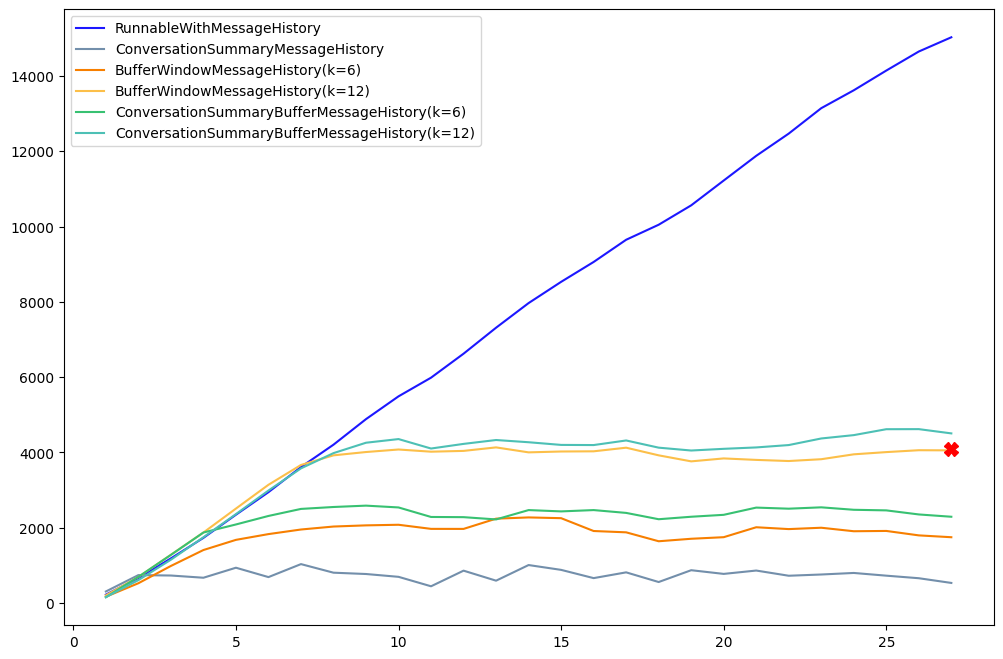

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.show()

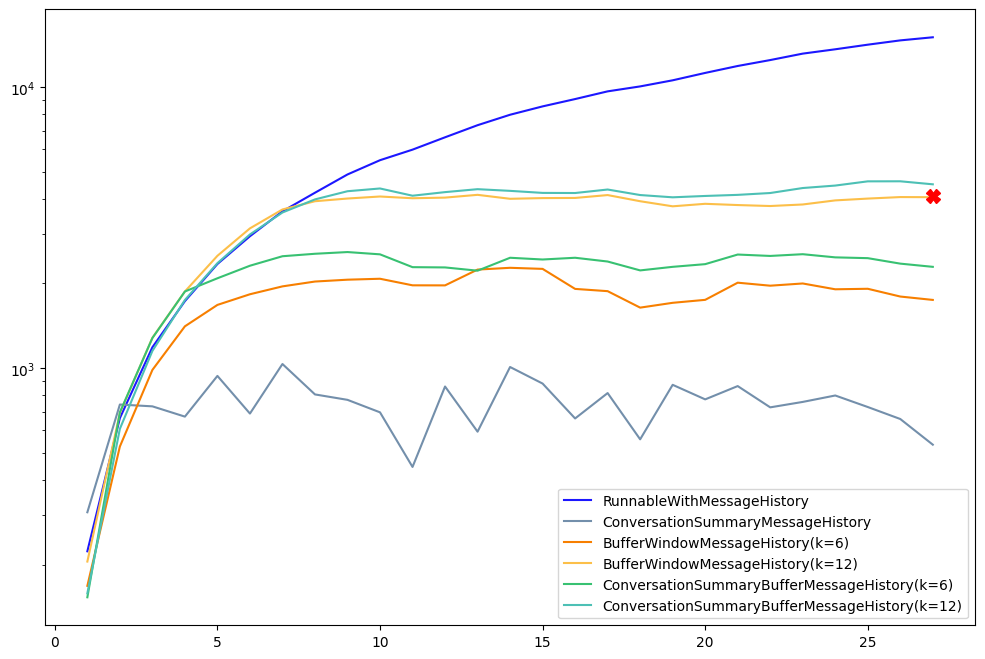

In [42]:
plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()